In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
project_root = os.path.abspath(os.getcwd())

data_dir = os.path.join(os.path.dirname(project_root))

results_dir = os.path.join(data_dir, 'results')

figures_dir = os.path.join(data_dir, 'figures')

# read results
results_basecase_summer = pd.read_csv(os.path.join(results_dir, 'results_basecase_summer.csv'),sep=',')
results_basecase_winter = pd.read_csv(os.path.join(results_dir, 'results_basecase_winter.csv'), sep=',')
results_case_1_winter = pd.read_csv(os.path.join(results_dir, 'results_case_1_winter.csv'), sep=',')
results_case_2_summer = pd.read_csv(os.path.join(results_dir,'results_case_2_summer.csv'), sep=',')
results_case_2_winter = pd.read_csv(os.path.join(results_dir,'results_case_2_winter.csv'), sep=',')
results_case_3_winter = pd.read_csv(os.path.join(results_dir,'results_case_3_winter.csv'), sep=',')
results_case_3_summer = pd.read_csv(os.path.join(results_dir,'results_case_3_summer.csv'), sep=',')


In [3]:
#print column names of all the dfs
print('results_basecase_summer' , results_basecase_summer.columns)
print('results_case_1_winter' , results_case_1_winter.columns)
print('results_case_2_summer' , results_case_2_summer.columns)
print('results_case_3_summer' , results_case_3_summer.columns)#

results_basecase_summer Index(['timestamp', 'Spotmarket_(EUR/kWh)', 'Inflexible_Demand_(kWh)',
       'PV_energy_production_kWh', 'ev_at_home_binary', 'distance_driven',
       'ev_home_availability', 'weekday', 'Allowed_WM_summer', 'Allowed_dryer',
       'Total_Demand', 'Dishwasher_Start', 'Dishwasher_On',
       'Washing_Machine_Start', 'Washing_Machine_On', 'Dryer_Start',
       'Dryer_On', 'EV_SOC', 'EV_Charging', 'EV_On', 'Demand_Level',
       'Penalty_Cost', 'Electricity_Cost', 'Total_Cost'],
      dtype='object')
results_case_1_winter Index(['timestamp', 'Spotmarket_(EUR/kWh)', 'Inflexible_Demand_(kWh)',
       'PV_energy_production_kWh', 'Heating_Demand_(kWh)', 'ev_at_home_binary',
       'distance_driven', 'ev_home_availability', 'weekday',
       'Allowed_WM_summer', 'Allowed_dryer', 'Total_Demand',
       'Dishwasher_Start', 'Dishwasher_On', 'Washing_Machine_Start',
       'Washing_Machine_On', 'Dryer_Start', 'Dryer_On', 'EV_SOC',
       'EV_Charging', 'EV_On', 'Heatpump_P

### Plot PV Comparison Case 2 - Case 3

In [4]:
def plot_pv_comparison(
    df1,
    df2,
    save_filename,
    min_time,
    max_time,
    figsize=(20, 8)
):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(ncols=2, sharey=True, figsize=figsize)

    datasets = [df1, df2]
    labels = ["Case 2 - Curtailed & PV2H", "Case 3 - PV2G & PV2H"]
    y_labels = ["Energy (kWh)", ""]
    energy_cols = [["Curtailed", "PV2H"], ["PV2G", "PV2H"]]

    color_map_list = [
        {"Curtailed": "tab:blue", "PV2H": "tab:green"},
        {"PV2G": "orange", "PV2H": "tab:green"},
    ]

    all_handles = []
    all_labels = []

    for idx, (df, ax, energy_set, title) in enumerate(zip(datasets, axes, energy_cols, labels)):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.iloc[min_time:max_time]
        timestamps = df['timestamp']

        # Plot energy lines manually to capture handles
        for col in energy_set:
            line, = ax.plot(
                timestamps,
                df[col],
                drawstyle='steps-post',
                label=col,
                color=color_map_list[idx][col]
            )
            all_handles.append(line)
            if col not in all_labels:
                all_labels.append(col)

        ax.set_ylabel(y_labels[idx])
        ax.set_xlabel("Date")
        ax.set_title(title, fontsize=14)
        ax.grid(False)

        ax.set_xlim(timestamps.iloc[0].normalize(), timestamps.iloc[-1].normalize() + pd.Timedelta(days=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
        ax.xaxis.set_major_locator(mdates.DayLocator())

        # For the right subplot (idx == 1), completely remove left ticks and spine
        if idx == 1:
            ax.yaxis.set_visible(False)
            ax.spines["left"].set_visible(False)
        else:
            # Keep left subplot as is
            ax.tick_params(axis='y', which='both', left=True, labelleft=True)

        # Spotmarket price on twin axis
        ax2 = ax.twinx()
        spot_line, = ax2.plot(
            timestamps,
            df['Spotmarket_(EUR/kWh)'],
            '--',
            color='brown',
            label='Spotmarket Price'
        )
        ax2.grid(False)

        if idx == 1:
            ax2.set_ylabel("Spotmarket Price (EUR/kWh)", color='black', labelpad=10)
            ax2.tick_params(axis='y', labelright=True, labelcolor='black')
        else:
            ax2.set_ylabel("")
            ax2.set_yticklabels([])
            ax2.tick_params(axis='y', labelright=False, length=0)
            ax2.spines["right"].set_visible(False)

        all_handles.append(spot_line)
        all_labels.append("Spotmarket Price")

    # Deduplicate while preserving order
    seen = set()
    final_handles, final_labels = [], []
    for h, l in zip(all_handles, all_labels):
        if l not in seen:
            final_handles.append(h)
            final_labels.append(l)
            seen.add(l)

    # Deduplicate while preserving order
    seen = set()
    final_handles, final_labels = [], []
    for h, l in zip(all_handles, all_labels):
        if l not in seen:
            final_handles.append(h)
            final_labels.append(l)
            seen.add(l)

    # Move "Spotmarket Price" to the end if it exists
    if "Spotmarket Price" in final_labels:
        idx = final_labels.index("Spotmarket Price")
        # Pop and append at the end
        spot_handle = final_handles.pop(idx)
        spot_label = final_labels.pop(idx)
        final_handles.append(spot_handle)
        final_labels.append(spot_label)

    # Global bottom legend
    fig.legend(
        handles=final_handles,
        labels=final_labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=len(final_labels),
        fontsize=16,
        frameon=True
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    #plt.savefig(os.path.join(figures_dir, save_filename), dpi=400, bbox_inches='tight')
    plt.show()

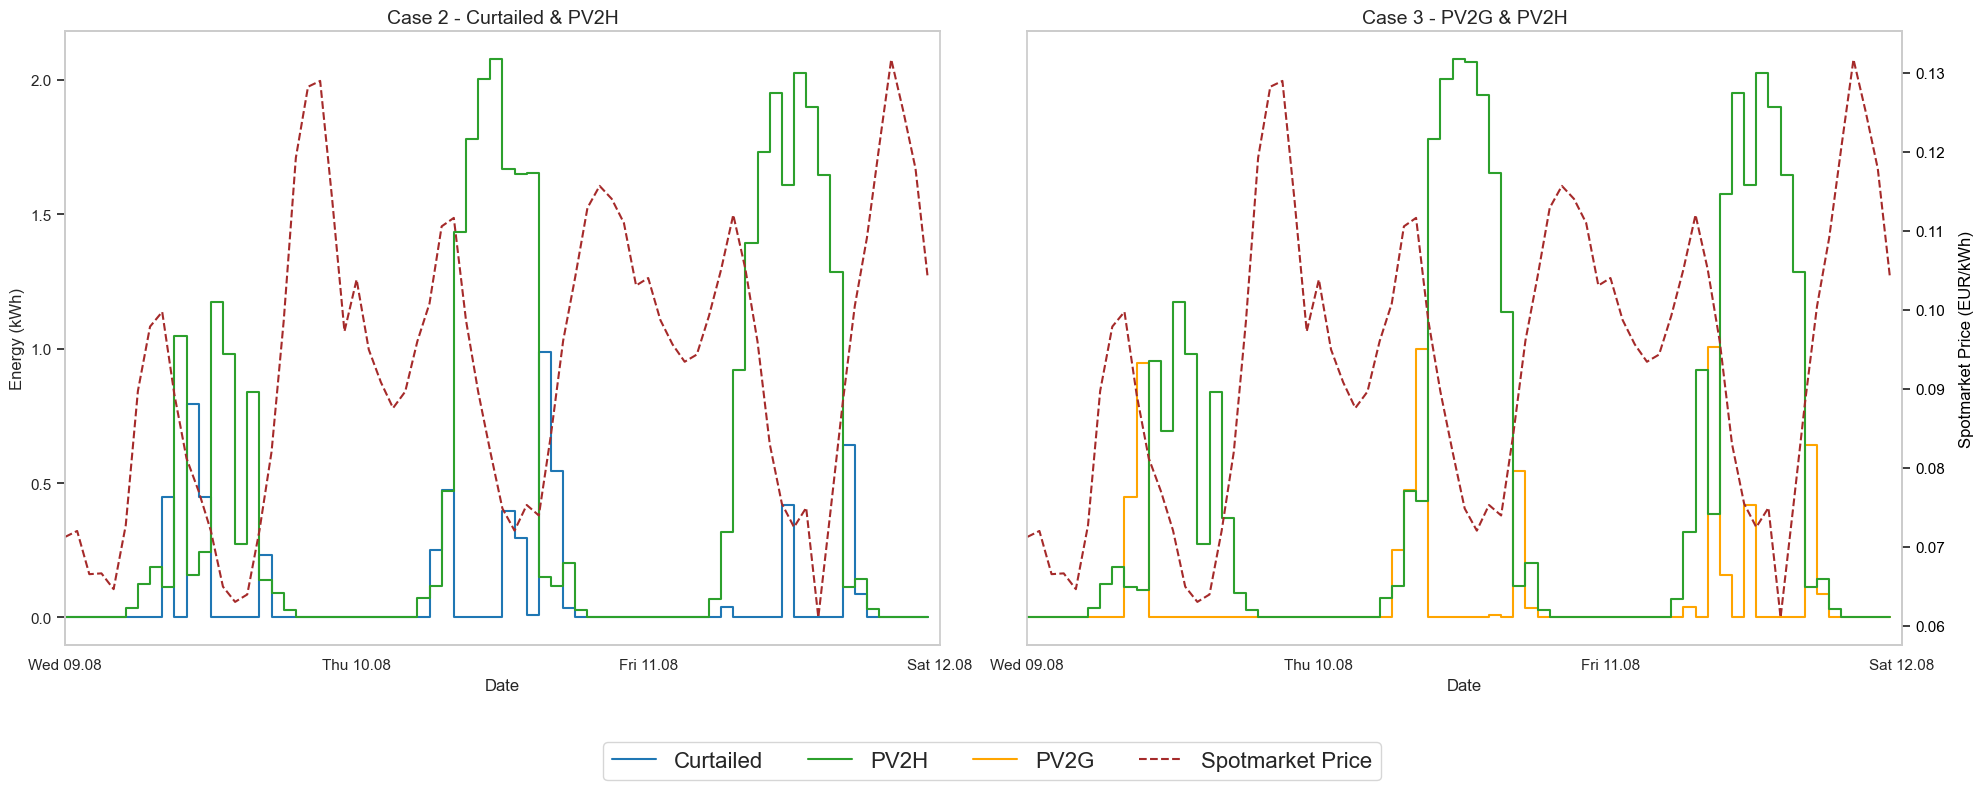

In [5]:
plot_pv_comparison(
    df1=results_case_2_summer,
    df2=results_case_3_summer,
    save_filename="PV_comparison.png",
    min_time=24 * 8,
    max_time=24 * 11
)

### EV Dynamics all Cases and Case 3 

In [20]:
def plot_ev_soc_and_charging_side_by_side(
    df_dict,
    title_left="EV SOC with Spot Prices",
    title_right="EV Dynamics, Case 3",
    save_filename="SOC_and_EV_dynamics_side_by_side.png",
    max_time=24 * 3,  # 3 days
    ev_capacity_kwh=70
):
    base_df = df_dict["Base Case"]
    case_3 = df_dict['Case 3']
    base_df['timestamp'] = pd.to_datetime(base_df['timestamp'])
    timestamps = base_df['timestamp'][:max_time]
    spotprice = base_df['Spotmarket_(EUR/kWh)'][:max_time]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True)

    all_handles = []
    all_labels = []

    # ---- LEFT PLOT: EV SOC (%) ---- #
    palette = sns.color_palette("tab10", n_colors=len(df_dict))
    for i, (label, df) in enumerate(df_dict.items()):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        soc_line, = ax1.plot(
            df['timestamp'][:max_time],
            df['EV_SOC'][:max_time] / ev_capacity_kwh * 100,
            label=f"SOC – {label}",
            linewidth=2,
            color=palette[i]
        )
        all_handles.append(soc_line)
        all_labels.append(f"SOC – {label}")

    ax1.set_title(title_left)
    ax1.set_xlabel("Date")
    ax1.set_ylabel("State of Charge (%)", fontsize=12, color='black')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.tick_params(axis='x', rotation=0)
    ax1.grid(False)


    # Spot price axis on LEFT (hidden ticks and labels)
    ax1b = ax1.twinx()
    spot_line_left, = ax1b.plot(
        timestamps, spotprice,
        linestyle='--', color='#a52a2a',
        linewidth=1.5
    )
    ax1b.set_ylabel("")
    ax1b.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)

    # ---- RIGHT PLOT ---- #
    soc = case_3['EV_SOC'][:max_time] / ev_capacity_kwh * 100
    charging = case_3['EV_Charging'][:max_time]

    # Spot price (visible on right)
    ax2b = ax2.twinx()
    spot_line_right, = ax2b.plot(
        timestamps, spotprice,
        linestyle='--', color='#a52a2a',
        linewidth=1.5
    )
    ax2b.set_ylabel("Spot Price (EUR/kWh)", color='black')
    ax2b.tick_params(axis='y', labelcolor='black')
    ax2b.set_ylabel("Spot Price (EUR/kWh)", fontsize=12, color='black')


    # EV charging (third axis on far right)
    ax2c = ax2.twinx()
    ax2c.spines['right'].set_position(('outward', 60))
    charging_bar = ax2c.bar(
        timestamps,
        charging,
        width=0.03,
        label="EV Dis-/charging (kWh)",
        color="#4c72b0",
        alpha=0.4
    )
    ax2c.set_ylabel("EV Dis-/charging (kWh)", fontsize=10)
    ax2c.tick_params(axis='y')

    case_3_index = list(df_dict.keys()).index("Case 3")
    case_3_color = palette[case_3_index]

    soc_line_right, = ax2.plot(
        timestamps, soc,
        label="SOC – Case 3",
        color=case_3_color,
        linewidth=2
    )

    ax2.set_title(title_right)
    ax2.set_xlabel("Date")
    ax2.set_ylabel("")
    ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
    ax2.xaxis.set_major_locator(mdates.DayLocator())
    ax2.tick_params(axis='x', rotation=0)
    ax2.grid(False)
    ax2c.set_ylabel("EV Dis-/charging (kWh)", fontsize=12, color='black')
    ax2c.tick_params(axis='y', labelcolor='black')


    # ---- Combine legend entries ---- #
    all_handles.extend([spot_line_right, charging_bar])
    all_labels.extend(["Spot Price", "EV Charging"])

    # Add EV-at-home status as a horizontal strip on both plots
    home_status = case_3['ev_at_home_binary'][:max_time]
    home_colors = ['lightgreen' if val == 1 else 'lightcoral' for val in home_status]

    # Bar height and position (just above x-axis)
    home_y = -5  # % for SOC (Y-axis), safe bottom placement
    bar_height = 2  # thin band

    # Left plot – use same timestamps
    for i, ts in enumerate(timestamps):
        ax1.bar(ts, bar_height, bottom=home_y, width=0.03, color=home_colors[i], align='center', linewidth=0)

    # Right plot – same logic
    for i, ts in enumerate(timestamps):
        ax2.bar(ts, bar_height, bottom=home_y, width=0.03, color=home_colors[i], align='center', linewidth=0)
    
    import matplotlib.patches as mpatches
    home_patch = mpatches.Patch(color='lightgreen', label='EV at Home')
    away_patch = mpatches.Patch(color='lightcoral', label='EV Away')
    all_handles.extend([home_patch, away_patch])
    all_labels.extend(['EV at Home', 'EV Away'])
    

    # Combine EV discharging from V2G and V2H
    discharging = (case_3['EV_V2G'][:max_time] + case_3['EV_V2H'][:max_time])  # make negative for downward bars

    # Add discharging bar to same axis as charging (ax2c)
    discharging_bar = ax2c.bar(
        timestamps,
        discharging,
        width=0.03,
        label="EV Discharging (kWh)",
        color="#e17c05",  # orange-ish
        alpha=0.5
    )

    # Add to legend
    all_handles.append(discharging_bar)
    all_labels.append("EV Discharging")
    


    # ---- Shared horizontal legend below both plots ---- #
    fig.legend(
        handles=all_handles,
        labels=all_labels,
        loc='lower center',
        ncol=8,
        fontsize=10,
        bbox_to_anchor=(0.5, -0.05)
    )


    # Turn off gridlines for all axes
    ax1.grid(False)
    ax1b.grid(False)
    ax2.grid(False)
    ax2b.grid(False)
    ax2c.grid(False)

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for legend

    if 'figures_dir' in globals():
        plt.savefig(os.path.join(figures_dir, save_filename), dpi=300, bbox_inches='tight')
    else:
        plt.savefig(save_filename, dpi=300, bbox_inches='tight')

    plt.show()

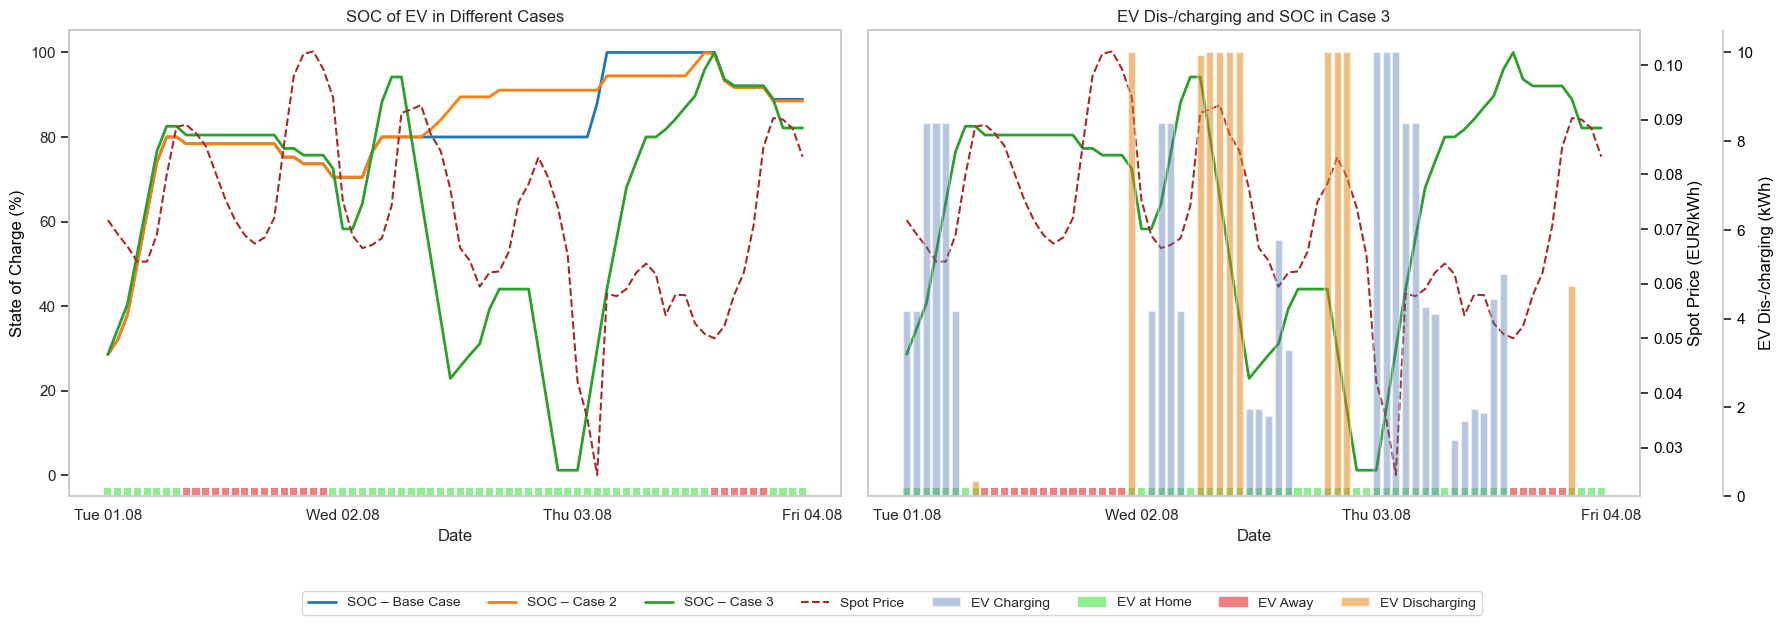

In [21]:
df_dict = {
    "Base Case": results_basecase_summer,
    #"Case 1": results_case_1_summer,
    "Case 2": results_case_2_summer,
    "Case 3": results_case_3_summer
}

plot_ev_soc_and_charging_side_by_side(
    df_dict,
    title_left="SOC of EV in Different Cases",
    title_right="EV Dis-/charging and SOC in Case 3",
    save_filename="SOC_and_charging_cases.png"
)